In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

2023-03-23 13:52:26.660029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Number of points, n
n = 4
# Dimension, d
d = 3

N = 1_000

psi = lambda M : M + M @ M

Cov_s = []
psi_vals = []
G_s = []
outers = []
for _ in range(N):
    # Sample points random normally:
    X = np.random.randn(d, n)
    # Covariances: these are the target:
    Cov_s.append(X @ X.T)
    # If we make a function, these would be the target:
    psi_vals.append(psi(X @ X.T))
    
    # This is the gram matrix (the inputs to our function):
    G_s.append(X.T @ X)
    # These are the outer products, the coefficients of our function.
    outers.append([[np.outer(X.T[i], X.T[j]) for i in range(n)] for j in range(n)])

In [3]:
G_s = np.array(G_s)

In [4]:
# Convert everything to a tensor
Cov_s = tf.convert_to_tensor(Cov_s, dtype=tf.float64)
G_s = tf.convert_to_tensor(np.concatenate([np.reshape(G_s, [N, n ** 2]), np.ones((N, 1))], axis=1), dtype=tf.float64)
outers = tf.convert_to_tensor(np.reshape(outers, [N, n ** 2, d,  d]), dtype=tf.float64)

In [5]:
# Although each has n² entries, the lower left triangle doesn't change--it's just easier to index this way.
# h = tf.Variable(tf.random.normal([n ** 2]))
f_ij = tf.Variable(tf.random.normal([n ** 2,n ** 2  + 1], dtype=tf.float64) / ((n ** 2) * (n ** 2 + 1)))

n_epochs = 20
# Currently, had to pick really small learning rate for stability?!
lr = 0.0001

# Currently, not batching, will batch later:
batch_size = 1000
loss_hist = []

In [6]:
@tf.function
def F(f_ij, G_s, outers):
    f_ij_x = tf.transpose((tf.tensordot(f_ij, G_s, [[1],[1]])))
    f_ij_x = tf.expand_dims(tf.expand_dims(f_ij_x, 2), 3)
    preds = tf.math.reduce_sum(f_ij_x * outers, 1)
    return preds

In [7]:
for _ in tqdm(range(1000)):
    with tf.GradientTape() as tape:
        preds = F(f_ij, G_s, outers)
        loss = tf.linalg.norm(preds - Cov_s) ** 2 / N
    f_ij = tf.Variable(f_ij - lr * tape.gradient(loss, f_ij))
    loss_hist.append(loss.numpy())

100%|██████████| 1000/1000 [00:09<00:00, 110.02it/s]


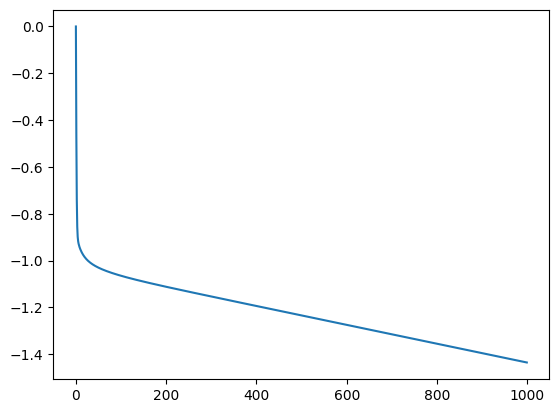

In [8]:
plt.plot(np.log10(loss_hist / loss_hist[0]))

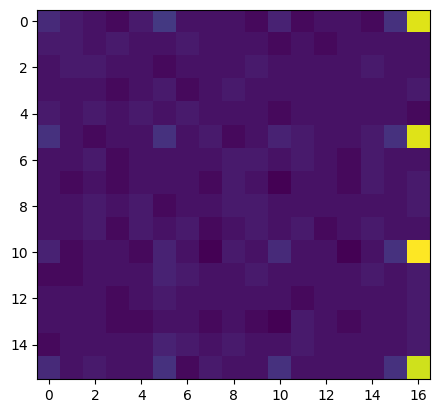

In [15]:
plt.imshow(np.round(f_ij.numpy(), 2))

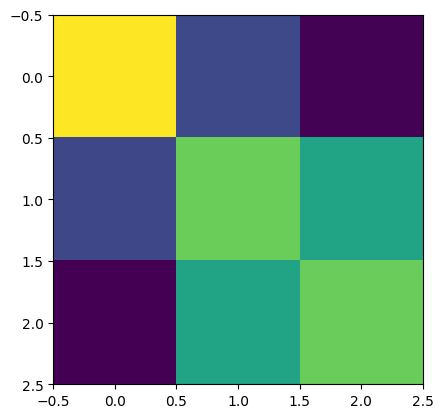

In [10]:
plt.imshow(F(f_ij, G_s[-2:-1], outers[-2:-1]).numpy().reshape(3,3))

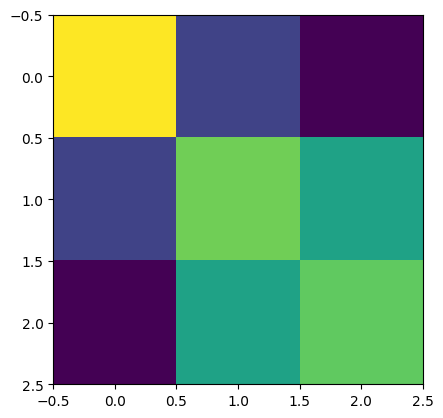

In [11]:
plt.imshow(Cov_s[-2:-1].numpy().reshape(3,3))

In [16]:
# loss_hist

In [13]:
@tf.function
def F(G_s, outers, h, f_ij):
    # h_x = h[1, 0] * 1
    # for k in range(n):
    #     for ell in range(k, n):
    #         h_x += h[k, ell] * G_s[:, k,ell]
    # F = tf.tensordot(h_x, Id, 0) # This is the tensor product
    F = tf.zeros([N, d, d])

    # 
    f_ij_x = np.zeros([N, n, n, 1, 1])
    for i in range(n):
        for j in range(n):
            f_ij_x[] = f_ij[i,j,1,0] * 1 # f_ij[i,j,1,0] is the constant term
            
            for k in range(n):
                for ell in range(k, n):
                    print(f"{k}, {n}")
                    f_ij_x += f_ij[i,j,k,ell] * G_s[:, k, ell]
            
            F += tf.expand_dims(tf.expand_dims(f_ij_x, 1), 2) * outers[:, i, j]
    return F

SyntaxError: invalid syntax (3331784726.py, line 14)

In [ ]:
# h_x = h_i[0] * Id + h_i[1] * 
for _ in range(10):
    with tf.GradientTape() as tape:
        pred = F(G_s, outers, h, f_ij)
        loss = (tf.linalg.norm(Cov_s - pred)** 2) / (N)
        loss_hist.append(loss)

    
    # Compute Gradients
    grad_h, grad_f_ij = tape.gradient(loss, (h, f_ij))

    # Apply Gradients
    h = tf.Variable(h - lr * grad_h)
    f_ij = tf.Variable(f_ij - lr * grad_f_ij)

In [ ]:
h_np = np.zeros((n,n))
f_ij_np = np.zeros((n,n,n,n))
for i in range(n):
    for j in range(n):
        f_ij_np[i, j, 1, 0] = 1

In [ ]:
h = tf.Variable(h_np, dtype=tf.float32)
f_ij = tf.Variable(f_ij_np, dtype=tf.float32)

In [ ]:
F(G_s[-2:-1], outers[-2:-1], h, f_ij) / 2

In [ ]:
Cov_s[-2:-1]

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[ 5.6173654 ,  2.2568538 , -2.2052712 ,  0.9280896 ],
        [ 2.2568538 ,  2.3307915 ,  0.47510394, -1.1372789 ],
        [-2.2052712 ,  0.47510394,  2.1666663 , -1.8077284 ],
        [ 0.9280896 , -1.1372789 , -1.8077284 ,  1.7547746 ]]],
      dtype=float32)>

In [ ]:
f_ij[0,0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.01438628, 0.3009125 ],
       [1.6402633 , 0.0353539 ]], dtype=float32)>

In [ ]:
f_ij[0,0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.89695853, -0.6205428 ],
       [-0.93277043,  0.7366636 ]], dtype=float32)>